# Transformer



In [1]:
import sys
sys.path.append('..')

In [2]:
import math
import pandas as pd
import mindspore
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.numpy as mnp
from d2l import mindspore as d2l

基于位置的前馈网络

In [3]:
class PositionWiseFFN(nn.Cell):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = d2l.Dense(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = d2l.Dense(ffn_num_hiddens, ffn_num_outputs)

    def construct(self, X):
        return self.dense2(self.relu(self.dense1(X)))

改变张量的最里层维度的尺寸

In [4]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.set_train(False)
ffn(mnp.ones((2, 3, 4)))[0]

Tensor(shape=[3, 8], dtype=Float32, value=
[[-1.68422937e-01, -4.72649217e-01, -4.08688366e-01 ...  1.73203319e-01,  1.62836313e-01,  4.43258807e-02],
 [-1.68422937e-01, -4.72649217e-01, -4.08688366e-01 ...  1.73203319e-01,  1.62836313e-01,  4.43258807e-02],
 [-1.68422937e-01, -4.72649217e-01, -4.08688366e-01 ...  1.73203319e-01,  1.62836313e-01,  4.43258807e-02]])

对比不同维度的层规范化和批量规范化的效果

In [5]:
from mindspore import Parameter
from mindspore.common.initializer import initializer
class LayerNorm(nn.Cell):
    def __init__(self, normalized_shape, gamma_init='ones', beta_init='zeros', epsilon=1e-7):
        """Initialize LayerNorm."""
        super(LayerNorm, self).__init__()
        if not isinstance(normalized_shape, (tuple, list)):
            raise TypeError(f"For '{self.cls_name}', the type of 'normalized_shape' should be tuple[int] or list[int], "
                            f"but got {normalized_shape} and the type is {type(normalized_shape)}.")
        self.normalized_shape = normalized_shape
        self.norm_ndim = len(normalized_shape)
        self.epsilon = epsilon
        self.gamma = Parameter(initializer(
            gamma_init, normalized_shape), name="gamma")
        self.beta = Parameter(initializer(
            beta_init, normalized_shape), name="beta")

    def construct(self, input_x):
        layer_norm = ops.LayerNorm(begin_norm_axis=input_x.ndim - self.norm_ndim,
                              begin_params_axis=input_x.ndim - self.norm_ndim,
                              epsilon=self.epsilon)
        y, _, _ = layer_norm(input_x, self.gamma, self.beta)
        return y

In [6]:
ln = LayerNorm((2,))
bn = nn.BatchNorm1d(2, use_batch_statistics=True)
X = mindspore.Tensor([[1, 2], [2, 3]], dtype=mindspore.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: [[-1.  1.]
 [-1.  1.]] 
batch norm: [[-0.99998 -0.99998]
 [ 0.99998  0.99998]]


使用残差连接和层规范化

In [7]:
class AddNorm(nn.Cell):
    """残差连接后进行层规范化。"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(1 - dropout)
        self.ln = LayerNorm(normalized_shape)

    def construct(self, X, Y):
        return self.ln(self.dropout(Y) + X)

加法操作后输出张量的形状相同

In [8]:
add_norm = AddNorm((3, 4), 0.5)
add_norm.set_train(False)
add_norm(mnp.ones((2, 3, 4)), mnp.ones((2, 3, 4))).shape

(2, 3, 4)

实现编码器中的一个层

In [9]:
class EncoderBlock(nn.Cell):
    """transformer编码器块。"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def construct(self, X, valid_lens):
        attns, attn_weights = self.attention(X, X, X, valid_lens)
        Y = self.addnorm1(X, attns)
        return self.addnorm2(Y, self.ffn(Y)), attn_weights

Transformer编码器中的任何层都不会改变其输入的形状

In [10]:
X = mnp.ones((2, 100, 24))
valid_lens = mindspore.Tensor([3, 2], mindspore.int32)
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.set_train(False)
encoder_blk(X, valid_lens)[0].shape

(2, 100, 24)

Transformer编码器

In [11]:
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens, embedding_table='normal')
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.CellList()
        for i in range(num_layers):
            self.blks.append(EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def construct(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * mnp.sqrt(self.num_hiddens))
        attention_weights = []
        for blk in self.blks:
            X, attn_weights = blk(X, valid_lens)
            attention_weights.append(attn_weights)
        return X, attention_weights

创建一个两层的transformer编码器

In [12]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.set_train(False)
encoder(mnp.ones((2, 100), mindspore.int32), valid_lens)[0].shape

[WARNING] KERNEL(941923,7f3338d39740,python):2021-11-25-03:33:22.894.356 [mindspore/ccsrc/backend/kernel_compiler/gpu/gpu_kernel_factory.cc:96] ReducePrecision] Kernel [TensorScatterUpdate] does not support int64, cast input 1 to int32.
[WARNING] PRE_ACT(941923,7f3338d39740,python):2021-11-25-03:33:22.894.432 [mindspore/ccsrc/backend/optimizer/gpu/reduce_precision_fusion.cc:83] Run] Reduce precision for [TensorScatterUpdate] input 1
[WARNING] KERNEL(941923,7f3338d39740,python):2021-11-25-03:33:22.901.265 [mindspore/ccsrc/backend/kernel_compiler/gpu/gpu_kernel_factory.cc:96] ReducePrecision] Kernel [TensorScatterUpdate] does not support int64, cast input 1 to int32.
[WARNING] PRE_ACT(941923,7f3338d39740,python):2021-11-25-03:33:22.901.331 [mindspore/ccsrc/backend/optimizer/gpu/reduce_precision_fusion.cc:83] Run] Reduce precision for [TensorScatterUpdate] input 1


(2, 100, 24)

Transformer解码器也是由多个相同的层组成

In [13]:
class DecoderBlock(nn.Cell):
    """解码器中第 i 个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def construct(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if len(state[2]) == self.i:
            key_values = X
        else:
            key_values = mnp.concatenate((state[2][self.i], X), axis=1)
        state_new = state[2] + (key_values,)
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = mnp.tile(mnp.arange(1, num_steps + 1), (batch_size, 1))
        else:
            dec_valid_lens = None

        X2, attn_1 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2, attn_2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), (enc_outputs, enc_valid_lens, state_new), \
                (attn_1, attn_2)

编码器和解码器的特征维度都是`num_hiddens`

In [14]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.set_train(False)
X = mnp.ones((2, 100, 24))
encoded, _ = encoder_blk(X, valid_lens)
state = (encoded, valid_lens, ())
decoder_blk(X, state)[0].shape

(2, 100, 24)

Transformer解码器

In [15]:
class TransformerDecoder(d2l.Decoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens, embedding_table='normal')
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.CellList()
        for i in range(num_layers):
            self.blks.append(DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = d2l.Dense(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return (enc_outputs, enc_valid_lens, ())

    def construct(self, X, state):
        X = self.pos_encoding(self.embedding(X) * mnp.sqrt(self.num_hiddens))
        attention_weights = ()
        for i, blk in enumerate(self.blks):
            X, state, attns = blk(X, state)
            attention_weights += attns
        return self.dense(X), state, attention_weights

In [16]:
class Transformer(d2l.EncoderDecoder):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(Transformer, self).__init__(encoder, decoder, **kwargs)

    def construct(self, enc_X, dec_X, X_valid_len):
        enc_outputs, _ = self.encoder(enc_X, X_valid_len)
        dec_state = self.decoder.init_state(enc_outputs, X_valid_len)
        dec_outputs, state, _ = self.decoder(dec_X, dec_state)
        return dec_outputs, state

训练

loss 0.000, 7640.8 tokens/sec


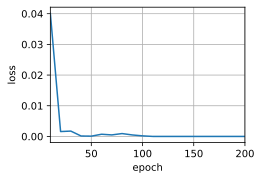

In [17]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs = 0.005, 200
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = (32,)

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = Transformer(encoder, decoder)


d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab)

将一些英语句子翻译成法语

In [18]:
from mindspore import context
context.set_context(mode=context.GRAPH_MODE)
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => reculez quoi quoi quoi quoi quoi quoi quoi quoi quoi,  bleu 0.000
i lost . => reculez quoi quoi quoi quoi quoi quoi quoi quoi quoi,  bleu 0.000
he's calm . => reculez quoi quoi quoi quoi quoi quoi quoi quoi quoi,  bleu 0.000
i'm home . => reculez quoi quoi quoi quoi quoi quoi quoi quoi quoi,  bleu 0.000


可视化transformer的注意力权重

In [19]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

NameError: name 'torch' is not defined

In [ ]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作

In [ ]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

In [ ]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

输出序列的查询不会与输入序列中填充位置的词元进行注意力计算

In [ ]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))